# EDA: Moving Average Speed Inference

In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob

window = 60

In [2]:
import psutil
    
ram_gb = psutil.virtual_memory().total / 2**30 # total physical memory in bytes
print(f"RAM: {ram_gb:.2f} GB")

RAM: 251.79 GB


In [3]:
# import
window = 60

csv_paths = glob(f'dataset/per-vehicle-moving-average/window-{window}/*.csv')

df = pd.concat([pd.read_csv(path, low_memory=False) for path in csv_paths])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30905074 entries, 0 to 128161
Data columns (total 27 columns):
 #   Column            Dtype  
---  ------            -----  
 0   time              object 
 1   altitude          float64
 2   vehicle_speed     float64
 3   accel             float64
 4   decel             float64
 5   lon               float64
 6   lat               float64
 7   vehicle_id        int64  
 8   osmid             object 
 9   lanes             float64
 10  speed_kph         float64
 11  length            float64
 12  dist_to_edge      float64
 13  barangay          object 
 14  hour              int64  
 15  dayofweek         int64  
 16  month             int64  
 17  residential       int64  
 18  institutional     int64  
 19  industrial        int64  
 20  commercial        int64  
 21  elevation         int64  
 22  pix_business      int64  
 23  pix_residential   int64  
 24  pix_industrial    int64  
 25  num_periods       int64  
 26  recomputed_spe

In [4]:
# quick eda on some cols as basis for filtering
inspect_cols = ['accel', 'decel', 'speed_kph', 'elevation', 'num_periods', 
                'pix_business', 'pix_residential', 'pix_industrial', 'lanes']
df[inspect_cols].describe()

,accel,decel,speed_kph,elevation,num_periods
count,3.090632e+07,3.090632e+07,3.090632e+07,3.090632e+07,3.090632e+07
mean,1.272281e+00,1.446541e+00,4.175950e+01,5.860810e+01,6.703973e+00
std,1.630303e+00,1.749992e+00,1.885087e+01,5.345039e+00,2.935308e+00
min,0.000000e+00,0.000000e+00,2.000000e+01,3.600000e+01,1.000000e+00
25%,0.000000e+00,0.000000e+00,3.000000e+01,5.500000e+01,5.000000e+00
50%,1.000000e+00,1.000000e+00,3.000000e+01,5.900000e+01,7.000000e+00
75%,2.000000e+00,2.000000e+00,6.000000e+01,6.200000e+01,9.000000e+00
max,2.000000e+01,2.000000e+01,8.000000e+01,2.070000e+02,5.800000e+01


In [5]:
df.isna().any()

time                False
altitude            False
vehicle_speed       False
accel               False
decel               False
lon                 False
lat                 False
vehicle_id          False
osmid               False
lanes               False
speed_kph           False
length              False
dist_to_edge        False
barangay            False
hour                False
dayofweek           False
month               False
residential         False
institutional       False
industrial          False
commercial          False
elevation           False
pix_business        False
pix_residential     False
pix_industrial      False
num_periods         False
recomputed_speed    False
dtype: bool

## Choosing a window sample count threshold

In [6]:
def clean_data(df):
    df['barangay'] = df['barangay'].fillna('Out-of-town')
    df = df.loc[df['barangay'] != 'Out-of-town']
    df['lanes'] = df['lanes'].fillna(1.0)
    return df

def filter_data(df, thresh):
    df = df.loc[df['num_periods'] >= thresh]
    return df

In [7]:
df = clean_data(df)

/tmp/ipykernel_904/1451052938.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lanes'] = df['lanes'].fillna(1.0)


In [8]:
max_ = df['num_periods'].max()
min_ = df['num_periods'].min()

thresholds = np.arange(min_, max_ + 1, 1)
percent_included = np.array([filter_data(df, i).shape[0] / df.shape[0] for i in thresholds]) * 100
num_included = np.array([filter_data(df, i).shape[0] for i in thresholds])

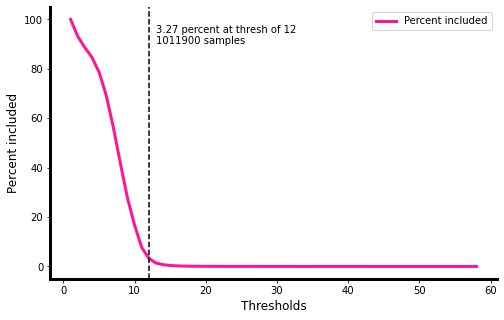

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(8, 5))

axes.plot(thresholds, percent_included, label='Percent included', c='deeppink', lw=3)
axes.legend(fontsize=10, loc='upper right')

# Hide the right and top spines
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

# set spines lw
axes.spines['left'].set_linewidth(3)
axes.spines['bottom'].set_linewidth(3)

use_thresh = 12
axes.axvline(use_thresh, linestyle='--', c='black')
axes.annotate(f"{percent_included[use_thresh - 1]:.2f} percent at thresh of {use_thresh}\n{num_included[use_thresh - 1]} samples", 
              xy=(use_thresh + 1, 90))

axes.set_xlabel('Thresholds', fontsize=12)
axes.set_ylabel('Percent included', fontsize=12)
plt.savefig('.jpg')
plt.show()

## Distribution comparison: Instantaneous vs Aggregate Speed

In [14]:
df[['vehicle_speed','recomputed_speed']].describe()

,vehicle_speed,recomputed_speed
count,3.090507e+07,3.090507e+07
mean,1.884206e+01,1.929879e+01
std,1.247464e+01,1.166195e+01
min,0.000000e+00,0.000000e+00
25%,9.000000e+00,1.100000e+01
50%,1.900000e+01,1.900000e+01
75%,2.800000e+01,2.800000e+01
max,9.700000e+01,8.900000e+01


<AxesSubplot:xlabel='recomputed_speed', ylabel='Density'>

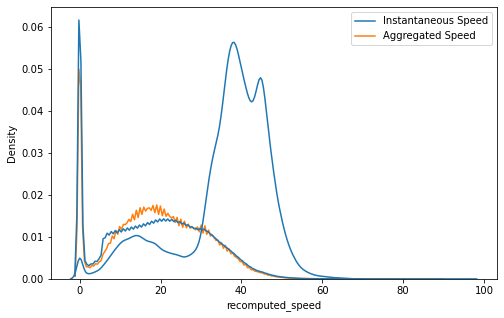

In [18]:
plot_labels = {
    'vehicle_speed': 'Instantaneous Speed',
    'recomputed_speed': 'Aggregated Speed'
}

data = df[['vehicle_speed', 'recomputed_speed']].rename(columns=plot_labels)

thresh = 12

fig, ax = plt.subplots(figsize=(8,5))



# End